## Flair Experiments

Use Fair to study context vectors of specific words.

In [131]:
from utils import *
import numpy as np
import os
from tqdm import tqdm_notebook
from collections import defaultdict
from flair.embeddings import FlairEmbeddings, DocumentPoolEmbeddings#, BertEmbeddings
from flair.embeddings import StackedEmbeddings
from flair.data import Sentence
import pandas as pd
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
from glob import glob
from collections import defaultdict

## Token Embeddings

In [25]:
path2range = lambda x: x.split("_")[-1].split(".")[0]

'1870-4'

In [129]:
pattern = r'\bvrouwelijk'
regex = re.compile(pattern, re.I)
sents2year = {}

for path in glob("./data/kranten_pd_18*.zip"):
    iterator = SentIterator(path,tokenized=False,sample_docs=10000)
    sents2year[path2range(path)] = [s for s in tqdm_notebook(iterator) if regex.findall(s)]

In [82]:
for k,v in sents2year.items():
    print(len(v))

1719
2076
1584


In [83]:
flair_forward_embedding = FlairEmbeddings('nl-forward')
flair_backward_embedding = FlairEmbeddings('nl-backward')

In [84]:
# now create the StackedEmbedding object that combines all embeddings
stacked_embeddings = StackedEmbeddings(
    embeddings=[flair_forward_embedding,flair_backward_embedding])

In [116]:
tokencontext = defaultdict(list)
labels = []
context = 3
for period, raw_sents in sents2year.items():
    for raw_sent in tqdm_notebook(raw_sents[:100]):
        sentence = Sentence(raw_sent)
        stacked_embeddings.embed(sentence)
    
        # now check out the embedded tokens.
        for i,token in enumerate(sentence):
            if "vrouw" in token.text:
                labels.append(' '.join([sentence[i].text for i in range(max(0,i-context),min(len(sentence),i+context+1))]))
                tokencontext[period].append(np.array(token.embedding))

In [117]:
tokencontext.keys()

dict_keys(['1870-4', '1875-6', '1860-4'])

In [118]:
X = np.concatenate([v for k,v in tokencontext.items()],axis=0)
print(X.shape)

(280, 4096)


In [119]:
names2colors = {n:c for n,c in zip(tokencontext.keys(),["r","b","g"])}
names2colors

{'1870-4': 'r', '1875-6': 'b', '1860-4': 'g'}

In [120]:
tsne = TSNE(n_components=2, random_state=0,metric='cosine')
X_2d = tsne.fit_transform(X)

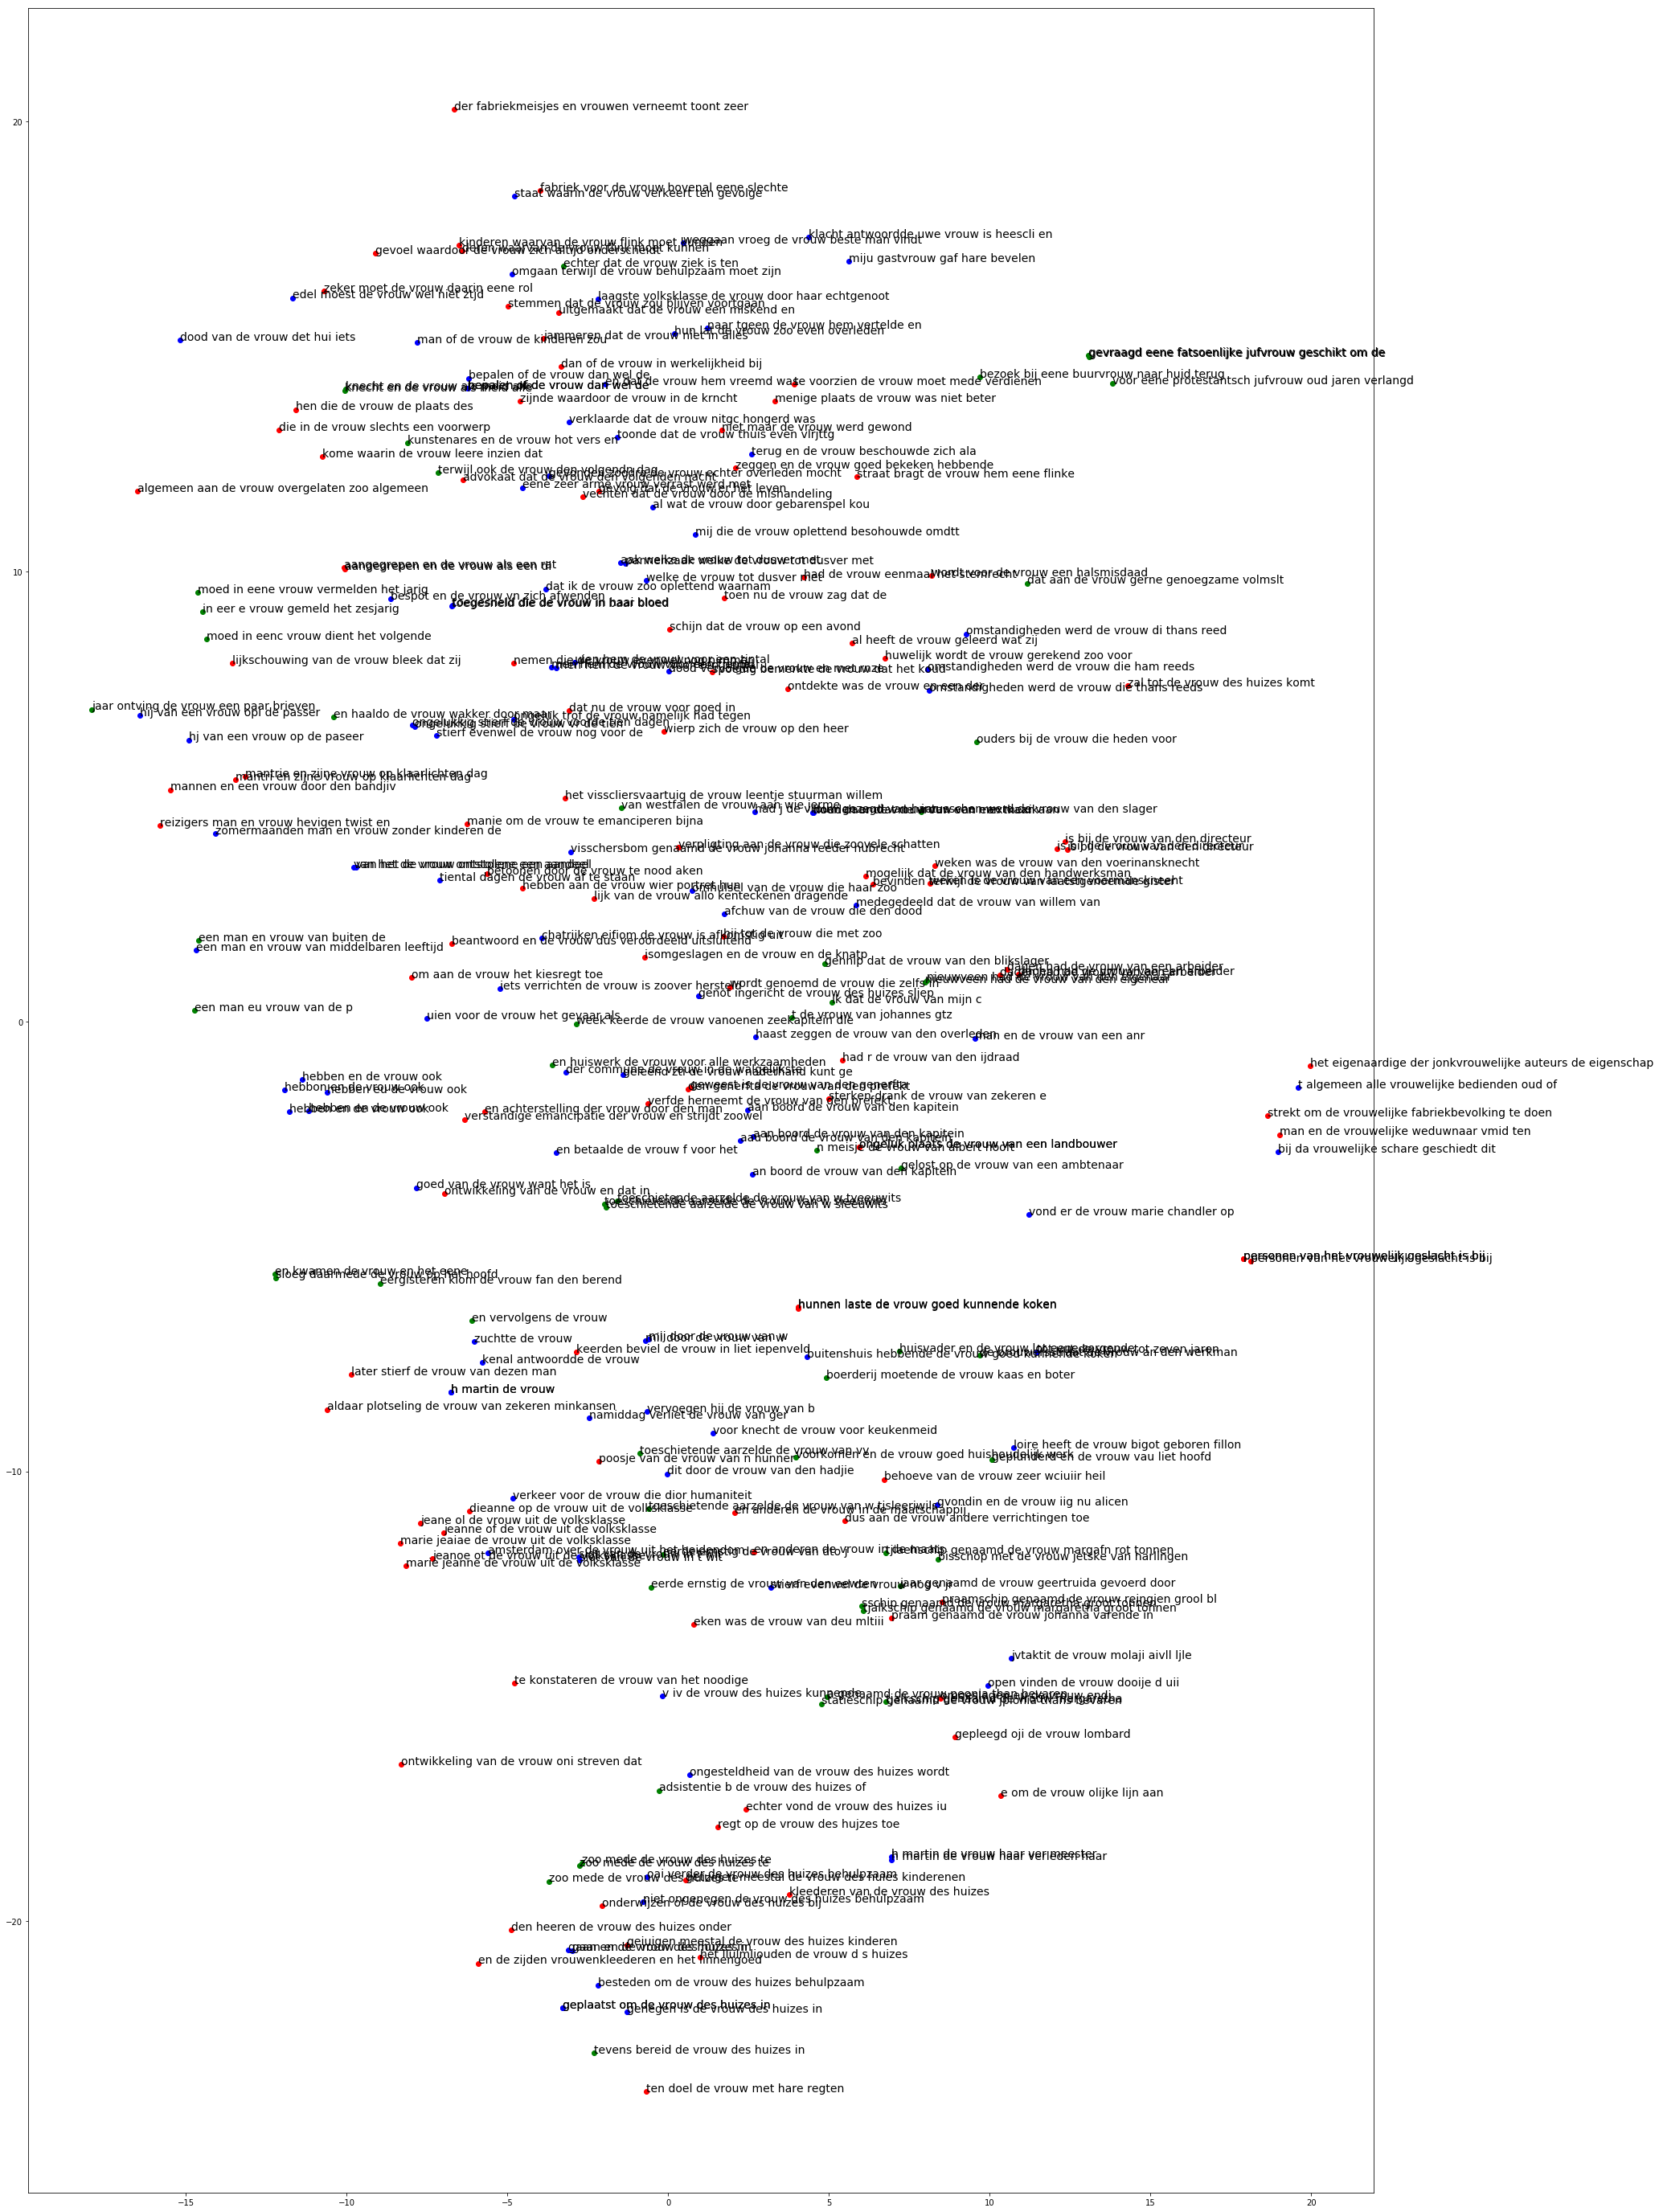

In [128]:
fig = plt.figure(figsize = (30,50))

i = 0

for k,v in tokencontext.items():
    for j in v:
        
        plt.scatter(X_2d[i, 0], X_2d[i, 1],c=names2colors[k])
        plt.annotate(labels[i], (X_2d[i, 0], X_2d[i, 1]),size=14)
        i+=1
    
    
plt.show()
fig.savefig("context_vectors.pdf", bbox_inches='tight')

In [80]:
for period, raw_sents in sents2year.items():
    for raw_sent in raw_sents[:200]:
        print(raw_sent+"\n")

voor de betrekking van huli t v dekw ij kb aan de burgerschool alhier de rereisehteo zijn behalve de acte ven bevoegdheid als hulponder viieres eem i vrouwelijke baodwerken de jaarwedde bedraagt oo

in de gevangenis van jeugdige vrouwelijke veroordeelden te montfoort bevindt zich een meisje veroordeeld tot vijf jaren gevangenisstraf

in newyork is een bankiershuis opgerigt aan welks hoofd eene dame staat terwijl alle bedienden van het vrouwelijk geslacht zijn

blijkens de resultaten der jongste telling van de bevolking te petersburg gevestigd is het aantal zielen thans geklommen tot tot het mannelijk geslacht behooren tot het vrcuwclijk inwoners

men zal zich eene voorstelling kunnen vormen van de benarde positie der passagiers maar tevens van de algemeene vreugde toen het bleek dat met uitzondering van een mannelijken reiziger geen van allen eenig belangrijk letsel had bekomen

j boeschi mannelijk oud j

a floris mannelijk oud j

mannelijke kinderen laat hij niet na

duid der vrouweli

## Document Embeddings

In [132]:
document_embeddings = DocumentPoolEmbeddings(
    embeddings=[flair_forward_embedding,flair_backward_embedding])

In [138]:
X = []
labels,colors = [],[]

context = 3
for period, raw_sents in sents2year.items():
    for raw_sent in tqdm_notebook(raw_sents[:100]):
        sentence = Sentence(raw_sent)
        document_embeddings.embed(sentence)
        X.append(sentence.get_embedding().detach().numpy())
        colors.append(names2colors[period])
        labels.append(' '.join([t.text for t in sentence.tokens if len(t.text) > 5 ][:5]))

In [139]:
tsne = TSNE(n_components=2, random_state=0,metric='cosine')
X_2d = tsne.fit_transform(X)

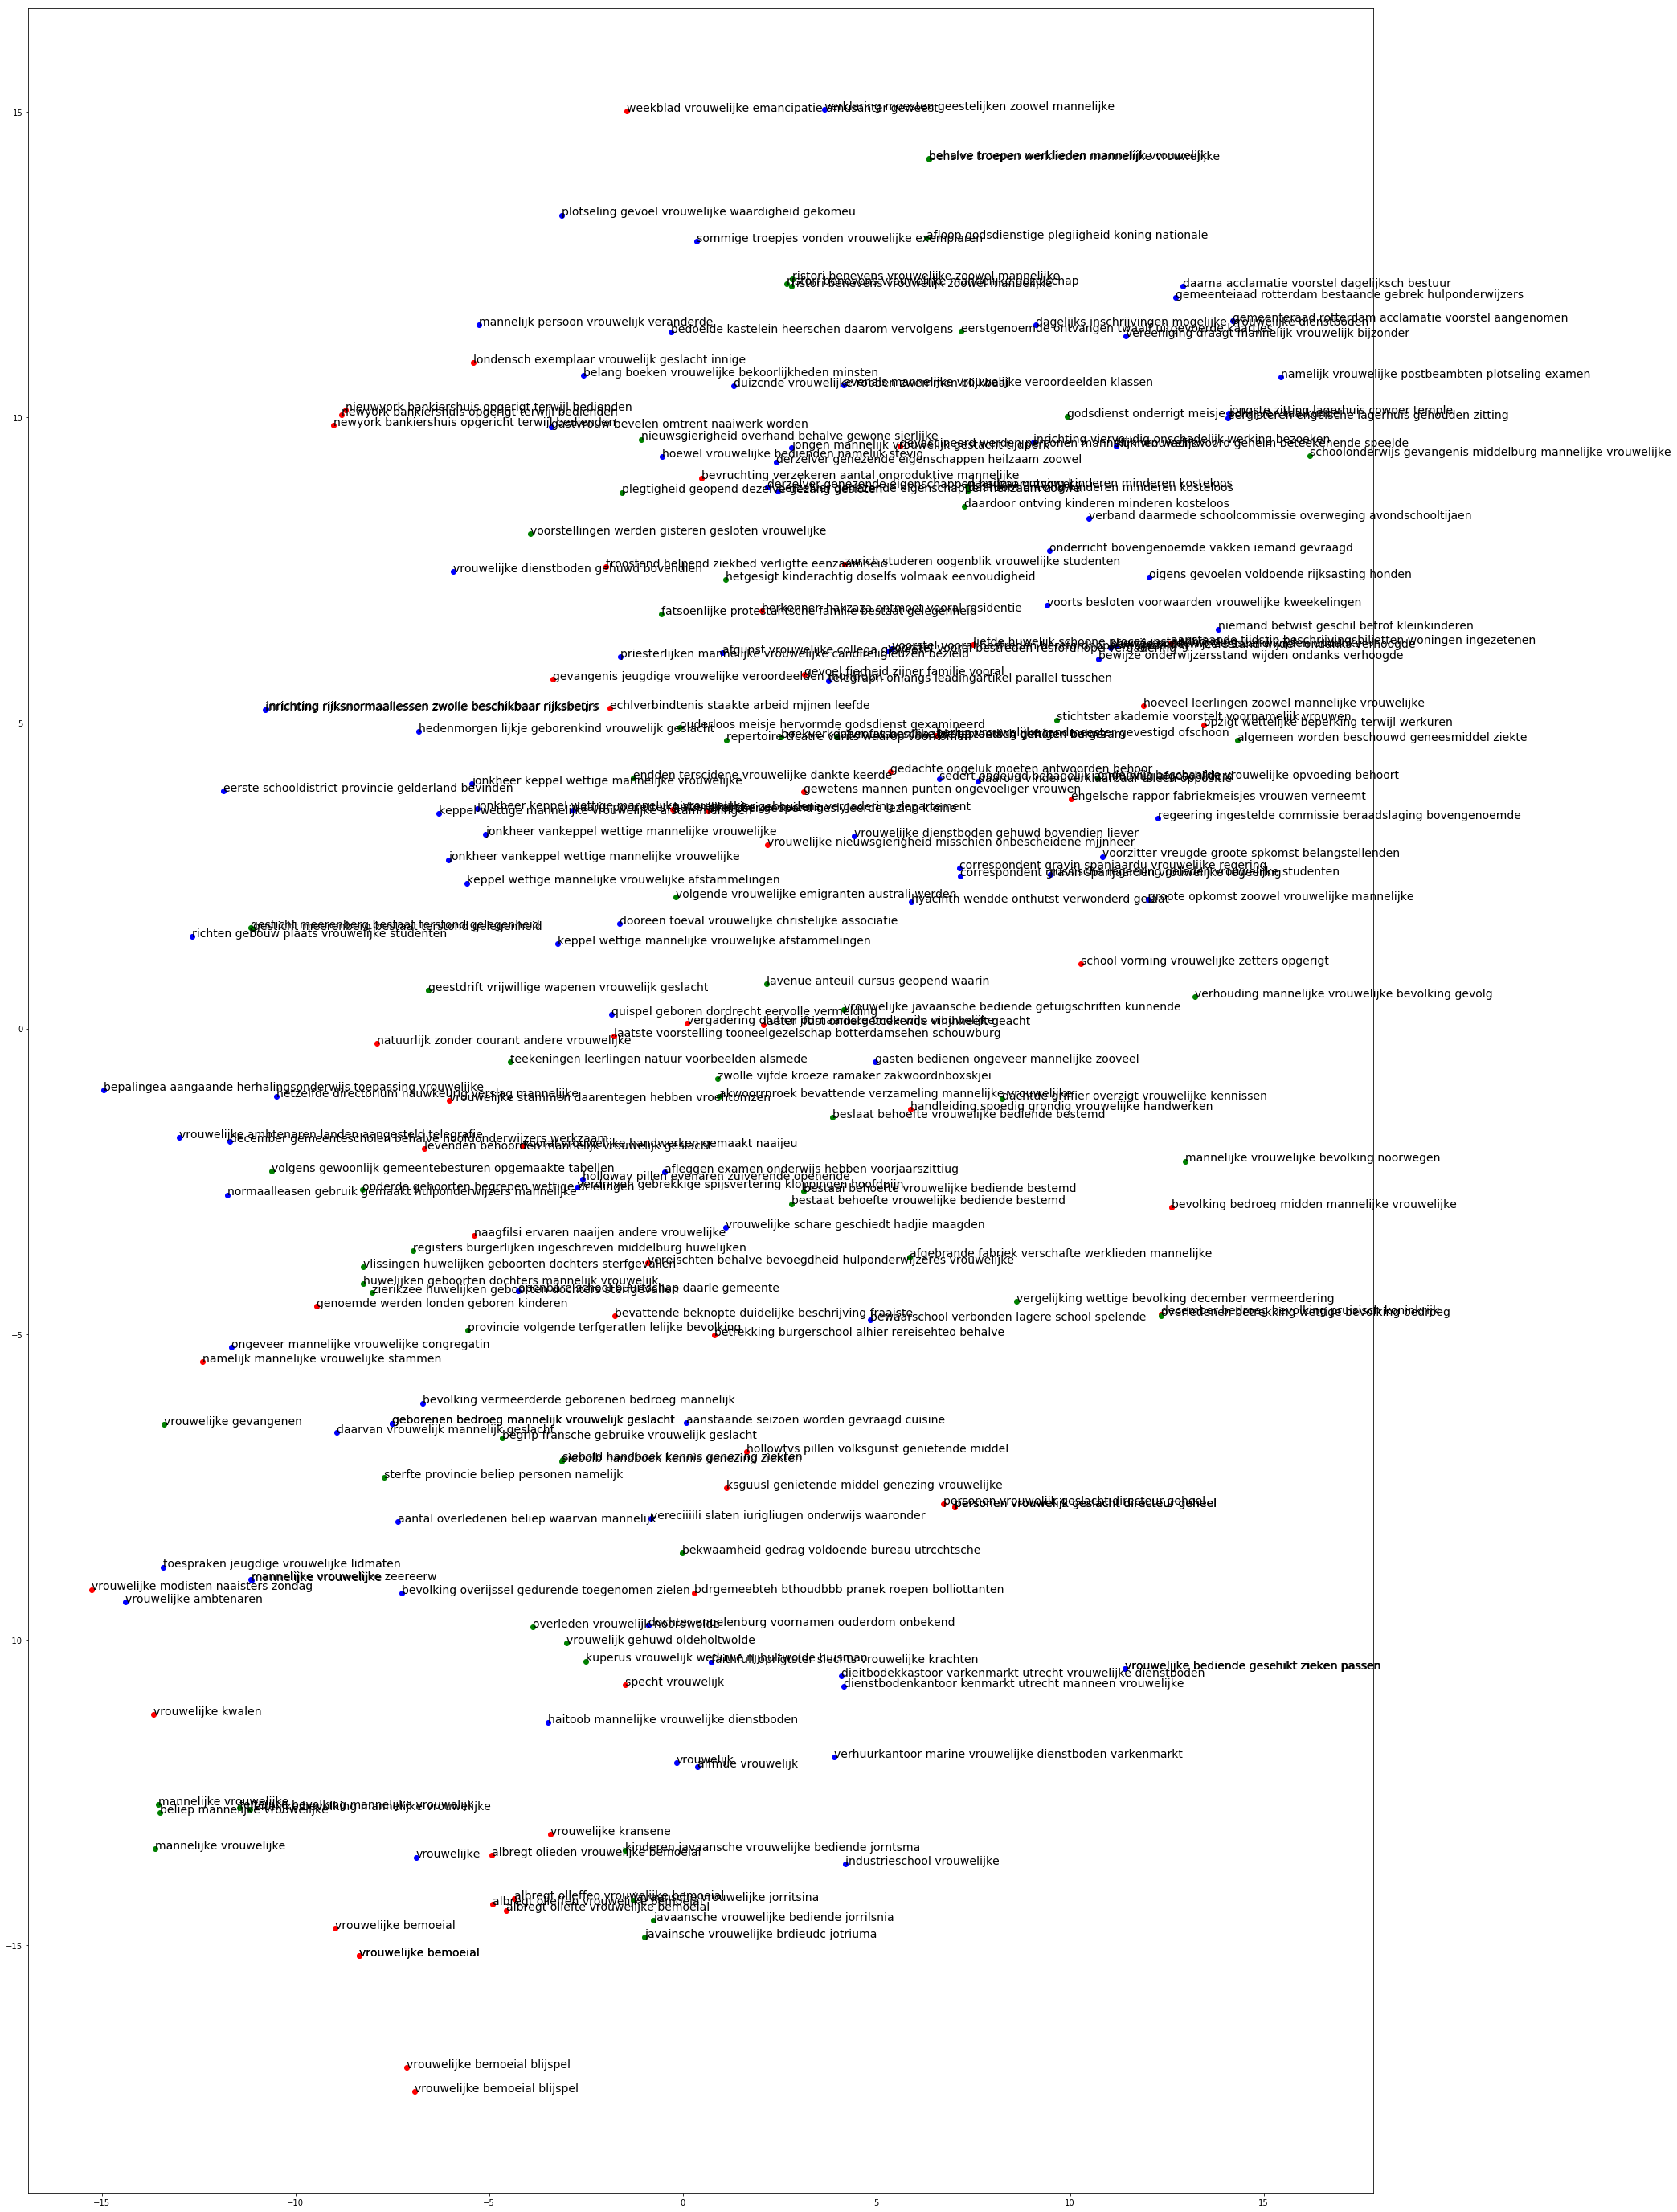

In [140]:
fig = plt.figure(figsize = (30,50))

for i,x in enumerate(X_2d):
    plt.scatter(X_2d[i, 0], X_2d[i, 1],c=colors[i])
    plt.annotate(labels[i], (X_2d[i, 0], X_2d[i, 1]),size=14)
    
    
plt.show()
fig.savefig("document_vectors.pdf", bbox_inches='tight')